# Deep End-to-end Causal Inference: Demo Notebook

This notebook provides a showcase of the features provided by our open source code for Deep End-to-end Causal Inference (DECI).

 - We begin with a simple two node example, showing how DECI can orient an edge correctly when non-Gaussian noise is present, and how DECI can then be used for treatment effect estimation
 - We show how different graph constraints can be incorporated into DECI
 - We showcase DECI on a larger graph example

## Notebook Setup

### Setup on AML
You can setup AML environment for causica by running the following commands on the terminal. Then, before running the notebook make sure you selected "causica" as your environment on top-right.

    conda create -n "causica" python==3.9 ipython
    conda activate causica
    conda install -y pip
    conda install -y ipykernel
    python -m ipykernel install --user --name causica --display-name causica
    sudo apt install graphviz-dev
    pip install git+https://github.com/microsoft/causica@9826ee9ba7dd63d72aaa0b3e0fd09636e38dd5bc
    pip install azureml-mlflow==1.46.0

<!-- pip install -r requirements.txt -->

### Setup on Databricks
Uncomment the following cell that will init-script on dbfs; set it up on your cluster. 
You can find more info on how to do so in this [link](https://learn.microsoft.com/en-us/azure/databricks/clusters/init-scripts#configure-a-cluster-scoped-init-script).

In [0]:
# %python
# dbutils.fs.put(
#     "dbfs:/databricks/init_scripts/install-pygraphviz-causica.sh",
#     """
#     #!/bin/bash
#     #install dependent packages
#     sudo apt-get install -y python3-dev graphviz libgraphviz-dev pkg-config
#     pip install pygraphviz
#     pip install git+https://github.com/microsoft/causica@9826ee9ba7dd63d72aaa0b3e0fd09636e38dd5bc""", True)

## Imports

In [0]:
# Some imports to get us started
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['PYTHONWARNINGS'] = 'ignore::FutureWarning'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Utilities
import os
import pandas as pd
import numpy as np
from datetime import datetime

# Causica imports
from causica.models.deci.deci import DECI
from causica.datasets.dataset import Dataset
from causica.datasets.variables import Variables

# Plots
import seaborn as sns
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# device: change cuda to cpu if GPU is not available; we recommend gpu training
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

## Data Preparation
We read the data from BogoVirus with random dose policy. We then convert the data in a format containing information of prev. and cur. days. Patients are sampled into train-test files. All the records of the the patients in trainset is used to train DECI model. The test set is used for validation of ATE estimations, which is not covered in this notebook.

The dataset is simulated before and here we only load it from SQL:

In [0]:
%sql

use bogovirus;

select drug, count(*) tally from patient_data_random_dose group by drug order by drug

drug,tally
0.0,2513490
0.1,323830
0.2,323671
0.3,323470
0.4,324823
0.5,324229
0.6,324727
0.7,324228
0.8,324186
0.9,324239


In [0]:
# spark.conf.set("spark.sql.execution.arrow.enabled", "true")

In [0]:
# read random-patient-data
df = sqlContext.sql("select * from patient_data_random_dose").toPandas()
df.head(5)

,patient_id,cohort,day_number,infection_prev,severity,cum_drug_prev,infection,drug,cum_drug,severity_next,toxicity,outcome
0,187444,0,7,52,16.773879,0.669760,53,0.0,0.401856,23.751267,0.004211,none
1,187444,0,8,53,23.751267,0.401856,58,0.8,0.561114,21.677300,0.031211,none
2,187444,0,9,58,21.677300,0.561114,67,0.0,0.336668,30.545030,0.001456,none
3,187444,0,10,67,30.545030,0.336668,74,0.0,0.202001,40.999533,0.000068,none
4,187444,0,11,74,40.999533,0.202001,81,0.0,0.121201,53.199487,0.000003,none


In [0]:
# cat_to_binary
df["die"]=(df["outcome"]=="die").astype(int)
df["recover"]=(df["outcome"]=="recover").astype(int)
df_ground = df.copy()

# drop cohort info, too
df=df.drop(columns=["cohort"])

In [0]:
# prep for temporal featurization
base_colnames=["severity", "infection", "drug", "cum_drug", "toxicity", "die", "recover"]
prev_colnames=["infection_prev", "cum_drug_prev"]

time_colname="day_number"
id_colname="patient_id"

df=df[[id_colname,time_colname]+base_colnames+prev_colnames].sort_values(by=[id_colname,time_colname]).reset_index(drop=True)
# df=df.sort_values(by=[id_colname,time_colname]).reset_index(drop=True)

In [0]:
# df.head(10)

In [0]:
# df.loc[df.day_number==0, :].head(5)

In [0]:
# df.loc[df.day_number==1, :].head(5)

In [0]:
# df.loc[df.day_number==2, :].head(5)

### Temporal Featurization

In [0]:
def extend_features_with_temporal_window(df_orig, id_columns, to_extend_columns, temp_start=1, temp_step_size=1, temp_num_steps=1):
    """
    temporal_start: what is the temporal distance of first temporal feature (prev & next). Default: 1
    (e.g., temporal_start=1 adds X_{t-1} & X_{t+1} or temporal_start=2 adds X_{t-2} & X_{t+2} to the featuresets)
    temp_step_size: the distance of two temporal features on each side of the feature; if the temp_num_steps=0, then this value does not matter. Default: 1
    temp_num_steps: the number of temporal features on each side. Default: 1
    
    If you want to include temporal features in multiple distances, you can change the temp_step_size & temp_num_steps to control the step size and the number of steps. For example if temp_start=1, temp_step_size=2, temp_num_steps=3, it will add X_{t-1} & X_{t+1} features to the features and then since temp_step_size equals to 2, it adds X_{t-3} & X_{t+3} to the featureset. As the temp_num_steps=3, it also adds X_{t-5} & X_{t+5}, which adds up to three temporal features on each side.
    """
    
    df_ext = df_orig.copy()
    colnames = list(df_ext.columns)
    
    for step in range(temp_num_steps):
        #shift values down by 1 => all cols but time
        df_tprev = df_ext[id_columns+to_extend_columns].groupby(id_columns).shift(temp_start + step*temp_step_size) # [len(id_colname):] #shift down
        # df_tnext = df_ext[id_columns+to_extend_columns].groupby(id_columns).shift(-(temp_start + step*temp_step_size))[len(id_colname):] #shift up

        # rename columns
        df_tprev.columns = ['prev' +str(temp_start + (step)*temp_step_size)+'_' + tagname for tagname in df_tprev.columns]
        # df_tnext.columns = ['next' +str(temp_start + (step)*temp_step_size)+'_' + tagname for tagname in df_tnext.columns]

        # column-names correction
        colnames = colnames + list(df_tprev.columns)
        # colnames = colnames + list(df_tnext.columns)

        # combine starting from original => then prev => then next
        # df_ext = pd.concat([df_ext, df_tprev, df_tnext], axis=1)
        df_ext = pd.concat([df_ext, df_tprev], axis=1)
    return df_ext, colnames

In [0]:
# df[[id_colname]+base_colnames+prev_colnames].groupby([id_colname]).shift(1)[1:]

In [0]:
# df[[id_colname]+base_colnames+prev_colnames].groupby([id_colname]).shift(1) #[len(id_colname):]

In [0]:
df_ext, colnames=extend_features_with_temporal_window(df_orig=df, id_columns=[id_colname],to_extend_columns=base_colnames+prev_colnames, temp_start=1, temp_step_size=1, temp_num_steps=1)

# correction to match the original dataset
df_ext["prev1_cum_drug"]=df_ext["cum_drug_prev"]
df_ext["prev1_infection"]=df_ext["infection_prev"]
df_ext = df_ext.drop(columns=["cum_drug_prev", "infection_prev", "prev1_infection_prev", "prev1_cum_drug_prev"])

In [0]:
# Correction of known NaN values 
df_ext.loc[df_ext.day_number==0, "prev1_drug"]=0
df_ext.loc[df_ext.day_number==0, "prev1_die"]=0
df_ext.loc[df_ext.day_number==0, "prev1_recover"]=0
df_ext.loc[df_ext.day_number==0, "prev1_toxicity"]=0

In [0]:
df_ext.loc[df_ext.day_number==0, :].head(5)

,patient_id,day_number,severity,infection,drug,cum_drug,toxicity,die,recover,prev1_severity,prev1_infection,prev1_drug,prev1_cum_drug,prev1_toxicity,prev1_die,prev1_recover
0,0,0,25.0,27,0.0,0.00,0.000000,0,0,NaN,21,0.0,0.0,0.0,0.0,0.0
10,1,0,17.0,34,0.0,0.00,0.000000,0,0,NaN,34,0.0,0.0,0.0,0.0,0.0
24,2,0,13.0,44,1.1,0.44,0.007256,0,0,NaN,36,0.0,0.0,0.0,0.0,0.0
39,3,0,18.0,32,0.0,0.00,0.000000,0,0,NaN,28,0.0,0.0,0.0,0.0,0.0
53,4,0,19.0,29,0.4,0.16,0.000017,0,0,NaN,22,0.0,0.0,0.0,0.0,0.0


In [0]:
df_ext.loc[df_ext.day_number==1, :].head(5)

,patient_id,day_number,severity,infection,drug,cum_drug,toxicity,die,recover,prev1_severity,prev1_infection,prev1_drug,prev1_cum_drug,prev1_toxicity,prev1_die,prev1_recover
1,0,1,30.200000,27,0.0,0.000,0.000000e+00,0,0,25.0,27,0.0,0.00,0.000000,0.0,0.0
11,1,1,22.100000,40,0.0,0.000,0.000000e+00,0,0,17.0,34,0.0,0.00,0.000000,0.0,0.0
25,2,1,3.422222,51,0.0,0.264,3.385506e-04,0,0,13.0,44,1.1,0.44,0.007256,0.0,0.0
40,3,1,23.000000,35,0.1,0.040,4.096000e-09,0,0,18.0,32,0.0,0.00,0.000000,0.0,0.0
54,4,1,16.903448,37,0.0,0.096,7.827578e-07,0,0,19.0,29,0.4,0.16,0.000017,0.0,0.0


In [0]:
df_ext.loc[df_ext.day_number==2, :].head(5)

,patient_id,day_number,severity,infection,drug,cum_drug,toxicity,die,recover,prev1_severity,prev1_infection,prev1_drug,prev1_cum_drug,prev1_toxicity,prev1_die,prev1_recover
2,0,2,35.920000,32,0.0,0.0000,0.000000e+00,0,0,30.200000,27,0.0,0.000,0.000000e+00,0.0,0.0
12,1,2,28.310000,43,0.0,0.0000,0.000000e+00,0,0,22.100000,40,0.0,0.000,0.000000e+00,0.0,0.0
26,2,2,8.864444,53,0.0,0.1584,1.579542e-05,0,0,3.422222,51,0.0,0.264,3.385506e-04,0.0,0.0
41,3,2,26.876923,42,0.0,0.0240,1.911030e-10,0,0,23.000000,35,0.1,0.040,4.096000e-09,0.0,0.0
55,4,2,22.293793,41,0.0,0.0576,3.652035e-08,0,0,16.903448,37,0.0,0.096,7.827578e-07,0.0,0.0


In [0]:
# df_ext.head(10)

In [0]:
df=df_ext.copy()
df_day0 = df[df.day_number==0]
df.head(2)

,patient_id,day_number,severity,infection,drug,cum_drug,toxicity,die,recover,prev1_severity,prev1_infection,prev1_drug,prev1_cum_drug,prev1_toxicity,prev1_die,prev1_recover
0,0,0,25.0,27,0.0,0.0,0.0,0,0,NaN,21,0.0,0.0,0.0,0.0,0.0
1,0,1,30.2,27,0.0,0.0,0.0,0,0,25.0,27,0.0,0.0,0.0,0.0,0.0


In [0]:
del df_ext

### Train-Test Split

In [0]:
# cohort
patient_cohort = list(set(df_day0.patient_id))
patient_cohort_seq = df.groupby("patient_id")["day_number"].count()

# train - test 
import random
random.seed(42)
random.shuffle(patient_cohort)
train_point= int(0.8*len(patient_cohort))
train_patient = patient_cohort[:train_point]
test_patient = patient_cohort[train_point:]

df_train = df[df["patient_id"].isin(train_patient)].sample(frac=1.0, replace=True, random_state=42)
df_test = df[df["patient_id"].isin(test_patient)]

In [0]:
df_all = df.drop(columns=[id_colname, time_colname])
df_train_cohort = df_train.drop(columns=[id_colname, time_colname])
df_test_cohort = df_test.drop(columns=[id_colname, time_colname])

In [0]:
print("DECI internal trainsize: ", int(0.8 * df_train_cohort.shape[0]))
print("DECI internal val & test size: ", int(0.1 * df_train_cohort.shape[0]))
print("Leave-out size: ", df_test_cohort.shape[0])

DECI internal trainsize:  4512394
DECI internal val & test size:  564049
Leave-out size:  1409459


In [0]:
df_train_cohort.shape

Out[28]: (5640493, 14)

In [0]:
df_train_cohort.head(2)

,severity,infection,drug,cum_drug,toxicity,die,recover,prev1_severity,prev1_infection,prev1_drug,prev1_cum_drug,prev1_toxicity,prev1_die,prev1_recover
2113649,45.847096,65,0.8,0.474783,0.011454,0,0,44.714786,62,0.6,0.257971,0.000295,0.0,0.0
5379729,61.060967,96,0.7,0.773433,0.214060,0,0,59.934512,94,1.3,0.822388,0.309357,0.0,0.0


### Create variables object

In [0]:
import os

# data directory
data_dir = 'data/'
os.makedirs(data_dir, exist_ok=True)

In [0]:
def create_variables_json(df, categorical_vars, variables_json_path, text_vars=None, target_column_names=None):
    """
    The method returns Variables object (causica.datasets.variables.Variables), and also saves the json file; 
    The saved json file is for potential future use and the returned object is sufficient for what causica expects. 

    df <pandas.DataFrame> dataset that variable types and boundries will be extracted from
    categorical_vars <dict> a dictionary of categorical variables & the number of categories for each. e.g., {"gender":2, "race": 6}.
    variables_json_path <str> filepath to save the variables dictionary

    returns <causica.datasets.variables.Variables> variables
    """
    if text_vars is None:
        text_vars = []
    variables_info = []

    for ident, column_name in enumerate(df.columns):
        query = True if target_column_names is None else column_name not in target_column_names 
        var = {
            "id": ident,
            "query": query,
            "name": column_name,
        }
        if column_name not in text_vars:
            var["type"] = "categorical" if column_name in categorical_vars else "continuous"
            var["type"] = "binary" if (var["type"]=="categorical" and categorical_vars[column_name]==2) else var["type"]
            var["lower"] = 0 if column_name in categorical_vars else np.nanmin(df[column_name])
            var["upper"] = (
                categorical_vars[column_name] - 1 if column_name in categorical_vars else np.nanmax(df[column_name])
            )
        elif column_name in text_vars:
            var["type"] = "text"
            var["overwrite_processed_dim"] = 768  # Sentence Transformer model has that dimension

        if target_column_names and column_name in target_column_names:
            var["group_name"]="targets"
        variables_info.append(var)
    variables = Variables.create_from_dict({"variables": variables_info, "metadata_variables": []})
    variables.save(variables_json_path)
    return variables

In [0]:
# This data pre-processing treat all variables as continuous, although some of them are ordinal --  categorical_vars={'status':3}
variables_json_path=data_dir + 'bogo_time/variables.json'
os.makedirs(data_dir + 'bogo_time', exist_ok=True)

# create variables object
variables = create_variables_json(df_all, categorical_vars={'die':2, 'recover':2,'prev1_die':2, 'prev1_recover':2}, variables_json_path=variables_json_path, text_vars=None, target_column_names=[])
varindex_to_name = {i: var.name for (i, var) in enumerate(variables)}
varname_to_index = {var.name:i for (i, var) in enumerate(variables)}

### Create Dataset object

In [0]:
def create_dataset_obj(df_input, variables):
  # Set up data in a suitable form for DECI to consume, using the loaded data types
  # data_mask = ~df_input.isna().to_numpy() # np.ones(numpy_data.shape)
  data_mask = ~np.isnan(df_input.to_numpy()) # deci can tolerate missing data; this mask help DECI distinguish 

  # na to zero
  numpy_data=df_input.fillna(0).to_numpy()
  # print(numpy_data)
  dataset = Dataset(train_data=numpy_data, train_mask=data_mask, variables=variables)
  return dataset

# create dataset object for train-data
train_dataset = create_dataset_obj(df_train_cohort, variables)

In [0]:
df_train_cohort.head()

,severity,infection,drug,cum_drug,toxicity,die,recover,prev1_severity,prev1_infection,prev1_drug,prev1_cum_drug,prev1_toxicity,prev1_die,prev1_recover
2113649,45.847096,65,0.8,0.474783,0.011454,0,0,44.714786,62,0.6,0.257971,0.000295,0.0,0.0
5379729,61.060967,96,0.7,0.773433,0.214060,0,0,59.934512,94,1.3,0.822388,0.309357,0.0,0.0
6158037,85.812281,92,0.3,0.453199,0.008664,0,0,79.817710,83,0.8,0.555331,0.029330,0.0,0.0
2789667,38.037314,73,0.0,0.163137,0.000019,0,0,27.943013,73,0.0,0.271895,0.000404,0.0,0.0
1960325,27.123440,53,0.0,0.459840,0.009455,0,0,34.795353,47,1.4,0.766400,0.202644,0.0,0.0


# Part 1: Graph Discovery

The following snippets step through the process of:
 - configuring and creating a DECI model
 - training a model with no graph constraints
 - training a model with graph constraints
 
*Note*: if you have already trained a DECI model, you can reload the model by skipping to the section below on "Loading a saved DECI model"

In [0]:
# we create a directory to save the results of all the experiments
outputs_root = "bogovirus/runs/"
os.makedirs(outputs_root, exist_ok=True)

In [0]:
device = "0" if torch.cuda.is_available() else "cpu"

## 1.1. Train with No Constraint

#### **Note** -- DECI configuration

The DECI model has a number of hyperparameters, but attention need not be paid to all of them. Here we highlight key hyperparameters that might be changed to improve performance:
 - `learning_rate` is the step size for the Adam optimizer. Decrease the learning rate if training is unstable
 - `var_dist_A_learning_rate` is the learning rate for the causal graph distribution
 - `standardize_data_mean` and `standardize_data_std` tell DECI to standarize the data by subtracting the mean and dividing by the standard deviation of each column. *Note*: this improves training, but you need to take care because treatment effects will now be computed in this standardized space
 - `max_auglag_inner_epochs` is the number of gradient steps taken in each "inner step" of the DECI optimization. Decrease this to speed up training (at the risk of training not converging). Increase this to learn a more accurate model, or when the dataset is larger.
 - `max_steps_auglag` is the maximum number of "inner steps" taken. Decrease this to end training early (e.g. before a DAG has been found) to speed up training
 - `base_distribution_type` is the type of DECI model that is trained. It should be either `gaussian` or `spline`. Use `spline` for highly non-Gaussian data, or to fit a better density model of the observational data.
 - `lambda_sparse` controls the coefficient of graph sparsity regularizer.
 
Other hyperparameters are less frequently changed.


To speed up training you can try the followings:
 - increasing `learning_rate`
 - increasing `batch_size` (reduces noise when using higher learning rate)
 - decreasing `max_steps_auglag` (go as low as you can and still get a DAG)
 - decreasing `max_auglag_inner_epochs`

Note that an undertrained model might be unsuccessful to converge to a DAG or may have less accurate predictions.

In [0]:
# DECI configurations
model_config = {
    "tau_gumbel": 0.25,
    "lambda_dag": 200.0,
    "lambda_sparse": 5.0,
    "lambda_prior": 0.0,
    # Choosing a Gaussian DECI model, alternative is "spline"/"gaussian"
    "base_distribution_type": "spline",
    "imputation": False,
    "spline_bins": 8,
    "var_dist_A_mode": "enco",
    "mode_adjacency": "learn",
    # ?
    'norm_layers': True, 
    'res_connection': True,
}

training_params = {
    # Setting higher learning rates can speed up training, but risks some instability
    "learning_rate": 1e-3,
    "var_dist_A_learning_rate": 1e-2,
    "batch_size": 512, #256,
    # This standarizes the data before training. The DECI model operates in standardized space.
    "standardize_data_mean": False, #True,
    "standardize_data_std": False, #True,
    "rho": 1.0,
    "safety_rho": 1e18,
    "alpha": 0.0,
    "safety_alpha": 1e18,
    "tol_dag": 1e-9,
    "progress_rate": 0.65,
    # We are setting this large to wait until we find a DAG
    "max_steps_auglag": 50,
    # We are setting this large to learn a more accurate model.
    "max_auglag_inner_epochs": 2000,
    "max_p_train_dropout": 0.2,
    "reconstruction_loss_factor": 1.0,
    "anneal_entropy": "noanneal",
}

In [0]:
df_train_cohort.head(2)

,severity,infection,drug,cum_drug,toxicity,die,recover,prev1_severity,prev1_infection,prev1_drug,prev1_cum_drug,prev1_toxicity,prev1_die,prev1_recover
2113649,45.847096,65,0.8,0.474783,0.011454,0,0,44.714786,62,0.6,0.257971,0.000295,0.0,0.0
5379729,61.060967,96,0.7,0.773433,0.214060,0,0,59.934512,94,1.3,0.822388,0.309357,0.0,0.0


In [0]:
model_id = f"bogo_{datetime.now():%Y_%m_%d_%H%M%S}"
model = DECI.create(model_id, save_dir=os.path.join(outputs_root, model_id), variables=variables, model_config_dict=model_config, device=device)
# model.set_graph_constraint(constraint_matrix)
model.run_train(train_dataset, training_params)

Saving logs to bogovirus/runs/bogo_2022_11_11_224107/train_output/summary
Auglag Step: 0
LR: 0.001
Inner Step: 100, loss: 111.66, log p(x|A): -111.66, dag: 4.62370619, log p(A)_sp: -0.00, log q(A): -0.000, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 2.66e-06, cts_mse_icgnn: 1.08e+04
Inner Step: 200, loss: 70.98, log p(x|A): -70.98, dag: 5.13483340, log p(A)_sp: -0.00, log q(A): -0.000, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 3.47e-06, cts_mse_icgnn: 8e+03
Inner Step: 300, loss: 49.26, log p(x|A): -49.26, dag: 6.31794115, log p(A)_sp: -0.00, log q(A): -0.000, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 4.74e-06, cts_mse_icgnn: 5.62e+03
Inner Step: 400, loss: 36.93, log p(x|A): -36.93, dag: 7.77590527, log p(A)_sp: -0.00, log q(A): -0.000, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 7.36e-06, cts_mse_icgnn: 3.94e+03
Inner Step: 500, loss: 28.83, log p(x|A): -28.83, dag: 9.94255178, log p(A)_sp: -0.00, log q(A): -0.000, H filled: 0.000, rec: 0.000, penalty_dag_

In [0]:
print("Saved as ", model_id)

Saved as  bogo_2022_11_03_013822


In [0]:
model_id="bogo_2022_11_03_013822"
# model = DECI.load(model_id, os.path.join(outputs_root, model_id), device=device)

In [0]:
pred_graph = model.networkx_graph()
pred_graph = nx.relabel_nodes(pred_graph, varindex_to_name)

In [0]:
def topological_plot(G):
    # G is a nx.DiGraph object
    for layer, nodes in enumerate(nx.topological_generations(G)):
        # `multipartite_layout` expects the layer as a node attribute, so add the
        # numeric layer value as a node attribute
        for node in nodes:
            G.nodes[node]["layer"] = layer
    # Compute the multipartite_layout using the "layer" node attribute
    # pos = nx.multipartite_layout(G, subset_key="layer")
    pos = nx.shell_layout(G) #, subset_key="layer")
    fig, ax = plt.subplots()
    nx.draw_networkx(G, pos=pos, ax=ax)
    ax.set_title("DAG layout in topological order")
    fig.tight_layout()
    plt.show()

In [0]:
# topological_plot(pred_graph)

## 1.2. Adding domain-specific graph constraints
To improve the quality of the learned graph, it is possible to place constraints on the graph that DECI learns. The constraints come in two flavours:
 - *negative constraints* mean a certain edge cannot exist in the graph,
 - *positive constraints* mean a certain edge must exist in the graph.

In [0]:
# Constraint matrix coding is described in the DECI docstrings
# The constraint matrix has the same shape as the adjacency matrix
# A `nan` value means no constraint
# A 0 value means a negative constraint
# A 1 value means a positive constraint

constraint_matrix = np.full((len(varname_to_index.keys()), len(varname_to_index.keys())), np.nan, dtype=np.float32)

Temporal: First, we add temporal constraints, future does not cause the past

In [0]:
# temporal constraints
prev_idxes = [varname_to_index[var] for var in varname_to_index.keys() if var.startswith("prev1")]
cur_idxes = [varname_to_index[var] for var in varname_to_index.keys() if not var.startswith("prev1")]

for prev_idx in prev_idxes:
    constraint_matrix[cur_idxes, prev_idx] = 0.

Secondly, constraints on the outcomes not to be a cause for others

In [0]:
outcome_factors = ['die', 'recover']
outcome_idxes = [varname_to_index[var] for var in outcome_factors]
nonoutcome_idxes = [varname_to_index[var] for var in varname_to_index.keys() if var not in outcome_factors]

for out_idx in outcome_idxes:
    constraint_matrix[out_idx, nonoutcome_idxes] = 0.

In [0]:
# constraint_matrix

In [0]:
model_id_c = model_id + "_c"
model_c = DECI.create(model_id_c, save_dir=os.path.join(outputs_root, model_id_c), variables=variables, model_config_dict=model_config, device=device)
model_c.set_graph_constraint(constraint_matrix)
model_c.run_train(train_dataset, training_params)

Saving logs to bogovirus/runs/bogo_2022_11_03_013822_c/train_output/summary
Auglag Step: 0
LR: 0.001
Inner Step: 100, loss: 111.68, log p(x|A): -111.68, dag: 1.00794130, log p(A)_sp: -0.00, log q(A): -0.000, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 1.74e-07, cts_mse_icgnn: 1.09e+04
Inner Step: 200, loss: 70.75, log p(x|A): -70.75, dag: 1.22089018, log p(A)_sp: -0.00, log q(A): -0.000, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 2.62e-07, cts_mse_icgnn: 7.97e+03
Inner Step: 300, loss: 48.89, log p(x|A): -48.89, dag: 1.42416765, log p(A)_sp: -0.00, log q(A): -0.000, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 3.68e-07, cts_mse_icgnn: 5.6e+03
Inner Step: 400, loss: 36.15, log p(x|A): -36.15, dag: 1.61431400, log p(A)_sp: -0.00, log q(A): -0.000, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 4e-07, cts_mse_icgnn: 3.91e+03
Inner Step: 500, loss: 28.16, log p(x|A): -28.16, dag: 1.87305637, log p(A)_sp: -0.00, log q(A): -0.000, H filled: 0.000, rec: 0.000, penalty_dag

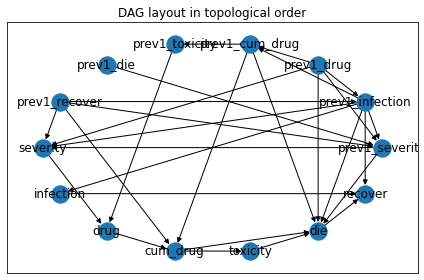

In [0]:
pred_graph_c = model_c.networkx_graph()
pred_graph_c = nx.relabel_nodes(pred_graph_c, varindex_to_name)
topological_plot(pred_graph_c)

Thirdly, we know severity is a cause for sevirity_next, infection_prev to infection_next, and drug to cum_drug

In [0]:
constraint_matrix_c2 = constraint_matrix.copy()

constraint_matrix_c2[varname_to_index['severity'], varname_to_index['drug']]=1.0
constraint_matrix_c2[varname_to_index['prev1_severity'], varname_to_index['prev1_drug']]=1.0
constraint_matrix_c2[varname_to_index['drug'], varname_to_index['severity']]=0.0
constraint_matrix_c2[varname_to_index['prev1_drug'], varname_to_index['prev1_severity']]=0.0

constraint_matrix_c2[varname_to_index['prev1_severity'], varname_to_index['severity']]=1.0
constraint_matrix_c2[varname_to_index['prev1_infection'], varname_to_index['infection']]=1.0

constraint_matrix_c2[varname_to_index['prev1_drug'], varname_to_index['severity']]=1.0
constraint_matrix_c2[varname_to_index['prev1_cum_drug'], varname_to_index['severity']]=1.0

constraint_matrix_c2[varname_to_index['drug'], varname_to_index['cum_drug']]=1.0
constraint_matrix_c2[varname_to_index['cum_drug'], varname_to_index['drug']]=0.0

constraint_matrix_c2[varname_to_index['prev1_drug'], varname_to_index['prev1_cum_drug']]=1.0
constraint_matrix_c2[varname_to_index['prev1_cum_drug'], varname_to_index['prev1_drug']]=0.0

constraint_matrix_c2

Out[64]: array([[nan, nan,  1., nan, nan, nan, nan,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [nan, nan, nan, nan, nan, nan, nan,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0., nan, nan,  1., nan, nan, nan,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [nan, nan,  0., nan, nan, nan, nan,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [nan, nan, nan, nan, nan, nan, nan,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  0.,  0.,  0.,  0., nan, nan,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  0.,  0.,  0.,  0., nan, nan,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 1., nan, nan, nan, nan, nan, nan, nan, nan,  1., nan, nan, nan,
        nan],
       [nan,  1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan],
       [ 1., nan, nan, nan, nan, nan, nan,  0., nan, nan,  1., nan, nan,
        nan],
       [ 1., nan, nan, nan, nan, nan, nan, nan, nan,  0., nan, nan, nan,
        nan],
       [nan, nan, nan, nan, nan, n

In [0]:
model_id_c2 = model_id + "_c2"
model_c2 = DECI.create(model_id_c2, save_dir=os.path.join(outputs_root, model_id_c2), variables=variables, model_config_dict=model_config, device=device)
model_c2.set_graph_constraint(constraint_matrix_c2)
model_c2.run_train(train_dataset, training_params)

Saving logs to bogovirus/runs/bogo_2022_11_03_013822_c2/train_output/summary
Auglag Step: 0
LR: 0.001
Inner Step: 100, loss: 111.35, log p(x|A): -111.35, dag: 1.09302295, log p(A)_sp: -0.00, log q(A): -0.000, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 1.87e-07, cts_mse_icgnn: 1.08e+04
Inner Step: 200, loss: 70.99, log p(x|A): -70.99, dag: 1.23264624, log p(A)_sp: -0.00, log q(A): -0.000, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 2.78e-07, cts_mse_icgnn: 8e+03
Inner Step: 300, loss: 49.32, log p(x|A): -49.32, dag: 1.33747585, log p(A)_sp: -0.00, log q(A): -0.000, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 3e-07, cts_mse_icgnn: 5.65e+03
Inner Step: 400, loss: 35.96, log p(x|A): -35.96, dag: 1.56170139, log p(A)_sp: -0.00, log q(A): -0.000, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 3.71e-07, cts_mse_icgnn: 3.92e+03
Inner Step: 500, loss: 27.02, log p(x|A): -27.02, dag: 1.58531424, log p(A)_sp: -0.00, log q(A): -0.000, H filled: 0.000, rec: 0.000, penalty_dag_

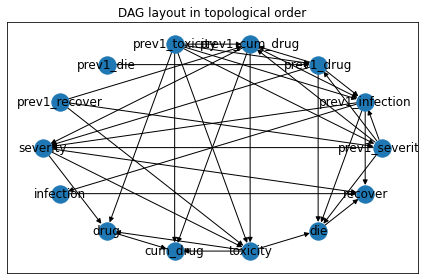

In [0]:
pred_graph_c2 = model_c2.networkx_graph()
pred_graph_c2 = nx.relabel_nodes(pred_graph_c2, varindex_to_name)
topological_plot(pred_graph_c2)

# Part 2: SimSim -- simulation for scenario analysis
DECI has also fitted an SCM that captures the functional relationship and error distribution of this dataset. We can estimate ATE and CATE using do-based sampling E\[X_{today}|do(X_{yesterday},drug=dose)].

## Treatment effect estimation -- Definitions

Treatment effects describe how a target variable (such as outcome_die) changes in response to an intervention on some other variables.
 - **Average Treatment Effect (ATE)** gives the difference between giving the drug to every patient, and not giving the treatment to any of them. This summarizes the overall or average effectiveness of the drug.
 - **Conditional Average Treatment Effect (CATE)** gives the difference between giving and not giving the drug, *restricted to a certain conditions or subgroup of patients*. For example, we could investigate the average treatment effect effect of drug on sever or nonsever patients (e.g., severity_now < 30. vs. severity_now > 109),.
 - **Individual Treatment Effect (ITE)** is the different in outcome_die between giving and not giving the drug *for one specific patient*.

In [0]:
import random
from scipy import stats

def is_out(row):
    return (row[
        "die"] > 0.9 or row[
        "recover"] > 0.9 or row[
        "prev1_die"] > 0.9 or row[
        "prev1_recover"] > 0.9)
    return False
    
def get_drug(row, dose):
    # depends on: severity
    # treatment threshold for today
    tx_threshold = random.randint(10, 50)
    drug = dose if row['severity'] > tx_threshold else 0
    return drug

def get_next_day(model, prev_day, colnames, varname_to_index, drug_dose=None, sample_count=1):
    cat_vars=[5, 6, 12, 13] #die/recover

    intervention_idxs=[]
    intervention_values=[]

    vars = [col for col in colnames if col.startswith('prev1_')]
    
    intervention_idxs += [varname_to_index[var] for var in vars]
    intervention_values += [prev_day[var[len("prev1_"):]] for var in vars]

    ### Model-based ATE estimate
    next_day = model.sample(
        sample_count, intervention_idxs=np.array(intervention_idxs), 
        intervention_values=np.array(intervention_values)
    ).cpu().numpy()
    next_day_agg = next_day.mean(axis=0)

    tx_threshold = random.randint(10, 50)
    if (drug_dose is not None) and (next_day_agg[0] > tx_threshold): #severity
        # drug dose
        intervention_idxs = [varname_to_index[
            "severity"], varname_to_index["drug"]] + intervention_idxs
        intervention_values = [next_day_agg[0], drug_dose] + intervention_values

        next_day = model.sample(
                sample_count, intervention_idxs=np.array(intervention_idxs), 
                intervention_values=np.array(intervention_values)
            ).cpu().numpy()

    next_day_agg = next_day.mean(axis=0)
    next_day_agg[cat_vars] = stats.mode(next_day[:,cat_vars], axis=0).mode[0]
    return next_day_agg # next_day.mean(axis=0)

def run_simsim(model, population, df_core, df_prev, varname_to_index, num_of_days, dose):
    # init
    df_none=df_core.copy()
    end_flags = [False] * population # dead or recovered

    # foreach day
    for k in range(1, num_of_days+1):
        np_simk=np.empty_like(df_prev)
        np_simk[:]=np.NaN

        # foreach patient
        for row_idx in range(np_simk.shape[0]):
            row = df_prev.iloc[row_idx,:]
            if end_flags[row_idx]:
                continue
            elif is_out(row):
                # dead or recovered
                # print('P', str(row_idx), 'gone')
                end_flags[row_idx] = True
                continue

            next_day = get_next_day(model, row, colnames=df_prev.columns, varname_to_index=varname_to_index, drug_dose=dose, sample_count=50)
            # print(next_day)
            np_simk[row_idx,:]=next_day
        
        df_prev=pd.DataFrame(np_simk, columns=df_prev.columns)
        # add day_number & patient_id
        df_dayk=df_prev.copy()
        # df_dayk.loc[:,df_prev.columns]=df_prev.loc[:,df_prev.columns].copy()
        df_dayk["day_number"]= [k] * population
        df_dayk["patient_id"]= df_core["patient_id"].values

        # add to the db
        df_none=df_none.append(df_dayk[df_none.columns], ignore_index=True)
        alive = len(end_flags) - sum(end_flags)

        if alive == 0:
            break
        print("Day", k, "is done, alive: ", alive)
        if k%10 == 0:
            df_none.to_csv(os.path.join(experiment_dir_c, 'simsim_data',str(k)+'.csv'))# No drug
    return df_none

In [0]:
experiment_dir_c=os.path.join(outputs_root, model_id_c)
os.mkdir(os.path.join(experiment_dir_c, 'simsim_data'))

In [0]:
experiment_dir_c2=os.path.join(outputs_root, model_id_c2)
os.mkdir(os.path.join(experiment_dir_c2, 'simsim_data'))

Condition on a particular dose -- here dose=0.2; we do the same for all the dose candidate to find the optimal dose policy:

In [0]:
population=5000 #everyone
df_core = df_train[df_train.day_number==0].sample(population, random_state=42).copy() 

#  setup
df_prev = df_core[df_train_cohort.columns] # sample instead
num_of_days=60
dose = 0.2

df02_c=run_simsim(model_c, population, df_core, df_prev, varname_to_index, num_of_days, dose)
df02_c.to_csv(os.path.join(experiment_dir_c, 'simsim_data', 'deci_constrainted_dose0.2_max60days' +'.csv'))

print(df02_c['die'].sum())
print(df02_c['recover'].sum())


Day 1 is done, alive:  5000
Day 2 is done, alive:  5000
Day 3 is done, alive:  5000
Day 4 is done, alive:  5000
Day 5 is done, alive:  5000
Day 6 is done, alive:  5000
Day 7 is done, alive:  5000
Day 8 is done, alive:  5000
Day 9 is done, alive:  5000
Day 10 is done, alive:  4991
Day 11 is done, alive:  4782


In [0]:
population=5000 #everyone
df_core = df_train[df_train.day_number==0].sample(population, random_state=42).copy() 

#  setup
df_prev = df_core[df_train_cohort.columns] # sample instead
num_of_days=60
dose = 0.2

df02_c2=run_simsim(model_c2, population, df_core, df_prev, varname_to_index, num_of_days, dose)
df02_c2.to_csv(os.path.join(experiment_dir_c2, 'simsim_data', 'deci_constrainted_dose0.2_max60days' +'.csv'))

print(df02_c2['die'].sum())
print(df02_c2['recover'].sum())
